## Bài toán:


> **Đánh giá điểm tín dụng sử dụng Decision Tree và Random Forest**

Mục tiêu:

- Xây dựng mô hình Decision Tree và Random Forest sử dụng thư viện sklearn.
- Áp dụng hai mô hình để giải bài toán thực tế (đánh giá điểm tín dụng).
- Sử dụng độ đo thích hợp để đánh giá chất lượng mô hình.

Vấn đề:

- Trong lĩnh vực tài chính, bài toán đánh giá tín dụng của người dùng là bài toán phổ biến và quan trọng. Ở đó, ngân hàng sẽ xác định liệu có cho một người dùng nào đó thực hiện khoản vay hay không, dựa trên thông tin về điểm tín dụng. Điểm tín dụng chính là con số phản ánh khả năng hoàn trả của người vay. Nhìn chung, đây là một bài toán phân lọai 2 lớp (good/bad score).
- Ngoài ra, một vấn đề thường gặp phải trong bài toán này đó: số lượng bad credits thường ít hơn nhiều so với số lượng good credits ==> Dữ liệu nhãn lớp mất cân bằng.

Dữ liệu:

- Cho dưới dạng bảng, mỗi hàng là một cá nhân vay, mỗi cột thể hiện một thuộc tính của cá nhân đó.
- Các trường thuộc tính tồn tại ở nhiều dạng: categorical, numeric (discrete / continuous). Thậm chí tên trường có thể được ẩn đi, hay giá trị thật sự được mã hõa để đảm bảo tính bảo mật của khách hàng.
- Hai tập dữ liệu sẽ sử dụng: [German credit](https://archive.ics.uci.edu/ml/datasets/Statlog+%28German+Credit+Data%29) và [Australian credit.](https://archive.ics.uci.edu/ml/datasets/Statlog+(Australian+Credit+Approval)


Mô hình hóa bài toán: bài toán phân loại nhị phân

- Đâu vào: $N$ vector $D$ chiều (ma trận cỡ $N \times D$), tương ứng $N$ cá thể với $D$ thuộc tính.
- Đầu ra: nhãn $0-1$ (0: bad credit, 1: good credit).

## Các bước thực hiện

### Import các thư viện cần thiết

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, ShuffleSplit, cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, f1_score, roc_auc_score

import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

random_state = 42

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data-numeric

### Tìm hiểu dữ liệu

In [ ]:
'''
- Tìm hiểu cấu trúc data tại trang web UCI
- Down các files, đặt trong folder data/
- Làm với phiên bản 'numeric'
'''
data_path = 'german.data-numeric'
credit=np.genfromtxt(data_path)
print(credit)
X,y = credit[:,:-1], credit[:,-1]
print(X.shape, y.shape)

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape)


[[ 1.  6.  4. ...  0.  1.  1.]
 [ 2. 48.  2. ...  0.  1.  2.]
 [ 4. 12.  4. ...  1.  0.  1.]
 ...
 [ 4. 12.  2. ...  0.  1.  1.]
 [ 1. 45.  2. ...  0.  1.  2.]
 [ 2. 45.  4. ...  0.  1.  1.]]
(1000, 24) (1000,)
(800, 24) (200, 24)


In [ ]:
print(len(y))

1000


### Khởi tạo các mô hình Decision Tree, Random Forest của Sklearn

In [ ]:
'''
- Decision Tree
https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
'''
DT = DecisionTreeClassifier(random_state=random_state)

'''
- Random Forest
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html
'''
RF = RandomForestClassifier(random_state=random_state)

In [ ]:
print('Demo DT and RF prediction')
DT.fit(X_train, y_train)
y_dt_pred = DT.predict(X_test)
print("-DT acc = {}".format(accuracy_score(y_test, y_dt_pred)))
print("-DT f1 = {}".format(f1_score(y_test, y_dt_pred)))
print(confusion_matrix(y_test, y_dt_pred))

Demo DT and RF prediction
-DT acc = 0.665
-DT f1 = 0.7632508833922261
[[108  33]
 [ 34  25]]


##### Bài 1: Chạy RF baseline

In [ ]:
# Code ở đây
RF.fit(X_train, y_train)
y_dt_pred = RF.predict(X_test)
print("-DT acc = {}".format(accuracy_score(y_test, y_dt_pred)))
print("-DT f1 = {}".format(f1_score(y_test, y_dt_pred)))
print(confusion_matrix(y_test, y_dt_pred))

-DT acc = 0.81
-DT f1 = 0.8749999999999999
[[133   8]
 [ 30  29]]


### Tìm kiếm siêu tham số

In [ ]:
# Một số hàm hỗ trợ
def grid_search(algorithm, n_jobs, dict_param):
    if algorithm == 'decision-tree':
        model = DecisionTreeClassifier()
    if algorithm == 'random-forest':
        model = RandomForestClassifier()
    classifier = GridSearchCV(estimator=model, cv=5, param_grid=dict_param,
                            n_jobs=n_jobs, scoring='f1')
    classifier.fit(X_train, y_train)
    print('Best model', end='')
    print(classifier.best_estimator_)
    return classifier.best_estimator_

def evaluate(model):
    print("Test Accuracy :", accuracy_score(y_test, model.predict(X_test)))
    print("Test f1 score :", f1_score(y_test, model.predict(X_test)))
    print("Test Confusion Matrix:")
    print(confusion_matrix(y_test, model.predict(X_test)))

#### Decision Tree

Best max_depth: 3
Test F1 score for the best model: 0.8417508417508417


Text(0.5, 1.0, 'DT validation curve for max_depth')

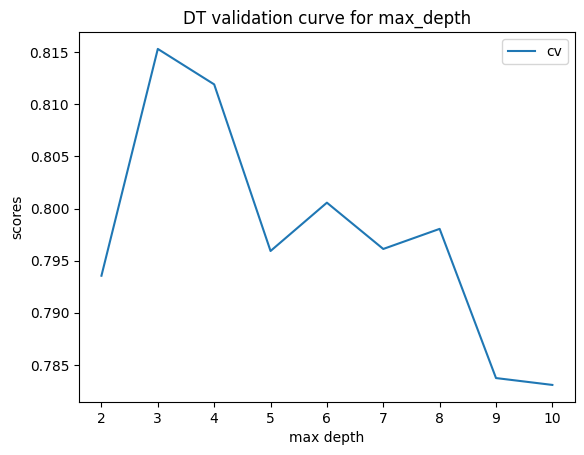

In [ ]:
# Trước hết, hãy thử khảo sát DT với tham số max_depth
cv_accuracies_by_depth = []
max_depth_values= np.arange(2,11)

for curr_max_depth in max_depth_values:
  tree= DecisionTreeClassifier(random_state=random_state, max_depth=curr_max_depth)

  # cross-validation
  val_scores= cross_val_score(estimator=tree, X=X_train, y=y_train, cv=5, scoring='f1')
  cv_accuracies_by_depth.append(val_scores.mean())

# Tìm giá trị max_depth tốt nhất dựa trên kết quả cross-validation
best_max_depth = max_depth_values[np.argmax(cv_accuracies_by_depth)]
print(f'Best max_depth: {best_max_depth}')

best_tree = DecisionTreeClassifier(random_state=random_state, max_depth=best_max_depth)
best_tree.fit(X_train, y_train)

# Đánh giá mô hình trên tập dữ liệu kiểm tra
best_pred = best_tree.predict(X_test)
best_test_f1_score = f1_score(y_test, best_pred)

print(f'Test F1 score for the best model: {best_test_f1_score}')

# Plot
plt.plot(max_depth_values, cv_accuracies_by_depth, label='cv')
plt.legend()
plt.xlabel('max depth')
plt.ylabel('scores')
plt.title('DT validation curve for max_depth')

In [ ]:
# Thử sử dụng GridSearchCV để khảo sát
dict_param = {
    'max_depth': [2, 3, 5, 7, 10, 20],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
best_tree_grid = grid_search('decision-tree', n_jobs=-1, dict_param=dict_param)


Best modelDecisionTreeClassifier(max_depth=5, min_samples_leaf=20)


In [ ]:
# Đánh giá best_tree GridSearchCV
best_pred_grid = best_tree_grid.predict(X_test)
best_test_f1_score_grid = f1_score(y_test, best_pred_grid)

print(f'Test F1 score for the best model grid: {best_test_f1_score_grid}')

Test F1 score for the best model: 0.8533333333333334


#### Random Forest

##### Bài 3: thực hành tương tự với RF

In [ ]:
# Bài tập
# Tương tự, thử khảo sát RF với số lượng cây n_estimators
# Hoàn thiện các đoạn code còn thiếu:

num_trees = [5, 10, 15, 20, 30, 50, 75, 100, 150]
cv_acc_by_n_estimators = []

for ntrees in num_trees:
    # Code ở đây:


# Tìm giá trị n_estimators tốt nhất dựa trên kết quả cross-validation
best_n_estimators = num_trees[np.argmax(cv_acc_by_n_estimators)]
print(f'Best n_estimators: {best_n_estimators}')

# Huấn luyện mô hình trên best_n_estimators
# Code ở đây:

# Đánh giá mô hình trên tập dữ liệu kiểm tra
# Code ở đây:

print(f'Test F1 score for the best forest: {best_forest_test_f1_score}')

plt.plot(num_trees, cv_acc_by_n_estimators, label='cv')
plt.legend()
plt.xlabel('No. of trees (n_estimators)')
plt.ylabel('Scores')
plt.title('Random-Forest: scores vs n_estimators');


In [ ]:
# Sử dụng GridSearch CV
dict_param = {
    'max_depth': [3, 11, 15, 24, 27],
    'min_samples_leaf': [1, 5, 7, 9, 15, 24],
    'max_features':  [4, 6, 10, 16],
    'n_estimators': [75]
}

# Tìm best_forest
# Code ở đây:


In [ ]:
# Đánh giá best_forest GridSearchCV
# Code ở đây:

print(f'Test F1 score for the best model grid: {best_test_f1_score_grid}')